In [8]:
import matplotlib.pyplot as plt
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cpu


In [9]:
def polynomial_function(x):
    return 3*x**3 + 2*x**2 - x + 0.5

In [10]:
# Generating synthetic training and testing data
np.random.seed(42)
x_train = np.random.uniform(-1, 1, 10000)
y_train = polynomial_function(x_train)

x_test = np.random.uniform(-1, 1, 2000)
y_test = polynomial_function(x_test)

x_train_tensor = torch.tensor(x_train, dtype=torch.float32).view(-1, 1).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1).to(device)
x_test_tensor = torch.tensor(x_test, dtype=torch.float32).view(-1, 1).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1).to(device)

# Create DataLoader for batch processing
batch_size = 32  # You can adjust the batch size
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

In [11]:
# Neural network definition
class OverParamNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(OverParamNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

In [12]:
def train_and_evaluate(hidden_size, epochs):
    model = OverParamNN(1, hidden_size, 1).to(device)
    optimizer = optim.SGD(model.parameters(), lr=0.01)
    criterion = nn.MSELoss()
    for epoch in range(epochs):
        model.train()
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
        if epoch % 50 == 0:
            print(f'Epoch {epoch}, Loss: {loss.item()}')

    # Evaluate the model
    model.eval()
    with torch.no_grad():
        predictions_test = model(x_test_tensor)
        mse_test = criterion(predictions_test, y_test_tensor).item()
        predictions_train = model(x_train_tensor)
        mse_train = criterion(predictions_train, y_train_tensor).item()

    return mse_train, mse_test, predictions_test.cpu(), predictions_train.cpu()

In [14]:
hidden_sizes = [10, 50, 100, 200, 500, 1000, 3000, 5000, 10000]
mse_values_test = []
mse_values_train = []
df_train = pd.DataFrame(x_train)
df_test = pd.DataFrame(x_test)

for size in hidden_sizes:
    print(size)
    mse_train, mse_test, predictions_test, predictions_train = train_and_evaluate(size, 500)
    mse_values_train.append(mse_train)
    mse_values_test.append(mse_test)
    df_train[size] = predictions_train
    df_test[size] = predictions_test


10
Epoch 0, Loss: 0.2972296476364136
Epoch 50, Loss: 0.014482153579592705
Epoch 100, Loss: 0.00829358957707882
Epoch 150, Loss: 0.04510892555117607
Epoch 200, Loss: 0.003626255551353097
Epoch 250, Loss: 0.024361502379179
Epoch 300, Loss: 0.04899993911385536
Epoch 350, Loss: 0.017778590321540833
Epoch 400, Loss: 0.02980504184961319
Epoch 450, Loss: 0.022376947104930878
50
Epoch 0, Loss: 0.18611817061901093
Epoch 50, Loss: 0.0003527741937432438
Epoch 100, Loss: 0.0009942090837284923
Epoch 150, Loss: 0.0006629750714637339
Epoch 200, Loss: 0.00011622332385741174
Epoch 250, Loss: 0.00014820534852333367
Epoch 300, Loss: 2.1769699742435478e-05
Epoch 350, Loss: 0.00016585993580520153
Epoch 400, Loss: 0.00015007123874966055
Epoch 450, Loss: 5.425832205219194e-05
100
Epoch 0, Loss: 0.3602744936943054
Epoch 50, Loss: 0.0009998729219660163
Epoch 100, Loss: 0.00021833697974216193
Epoch 150, Loss: 0.00016375648556277156
Epoch 200, Loss: 2.593166209408082e-05
Epoch 250, Loss: 0.00022026419173926115
E

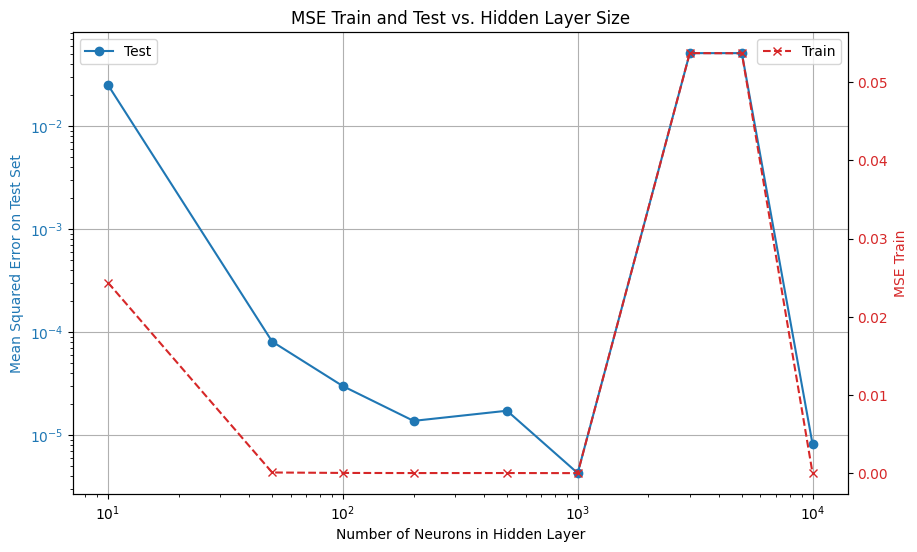

In [15]:
fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:blue'
ax1.set_xlabel('Number of Neurons in Hidden Layer')
ax1.set_ylabel('Mean Squared Error on Test Set', color=color)
ax1.plot(hidden_sizes, mse_values_test, marker='o', linestyle='-', color=color, label = 'Test')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('MSE Train', color=color)
ax2.plot(hidden_sizes, mse_values_train, marker='x', linestyle='--', color=color, label='Train')
ax2.tick_params(axis='y', labelcolor=color)

plt.title('MSE Train and Test vs. Hidden Layer Size')
plt.xscale('log')
ax1.set_yscale('log')
ax1.grid(True)
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.show()


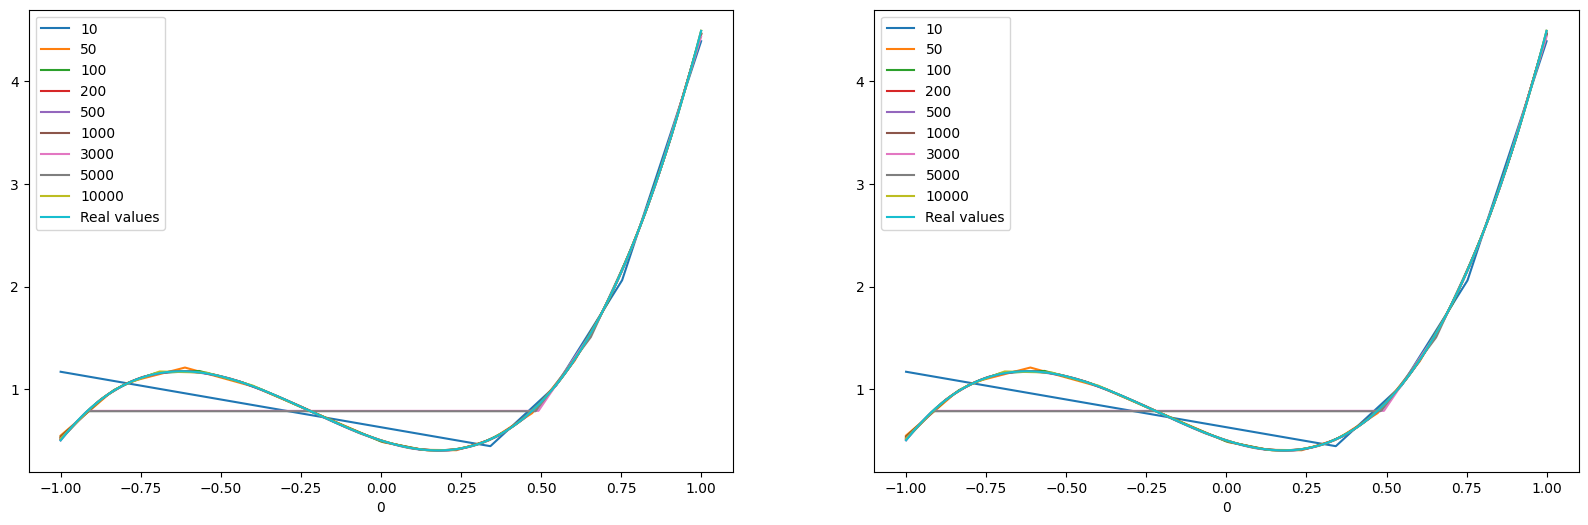

In [16]:
df_test.sort_values(by = 0, ascending=True, inplace=True,)
df_train.sort_values(by = 0, ascending=True, inplace=True)
df_test['Real values'] = polynomial_function(df_test[0])
df_train['Real values'] = polynomial_function(df_train[0])
fig, ax = plt.subplots(1, 2, figsize=(20, 6))

df_test.plot(x=0, ax=ax[0])
df_train.plot(x=0, ax=ax[1])
plt.show()


In [ ]:
input_size = 10
hidden_sizes = [10, 50, 100, 200, 500, 1000, 3000, 5000, 10000, 20000]
output_size = 1
num_points = 10000

# Generate synthetic training data
X_train = torch.randn(num_points, input_size).to(device)
true_weights = torch.randn(input_size, output_size).to(device)
y_train = X_train @ true_weights

# Generate synthetic test data
X_test = torch.randn(num_points, input_size).to(device)
y_test = X_test @ true_weights

class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleNN, self).__init__()
        self.hidden = nn.Linear(input_size, hidden_size)
        nn.init.normal_(self.hidden.weight, std=0.01)
        self.hidden.weight.requires_grad = False
        self.output = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        hidden = self.hidden(x)
        output = self.output(hidden)
        return output

train_mse = []
test_mse = []

for hidden_size in hidden_sizes:
    model = SimpleNN(input_size, hidden_size, output_size).to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)

    epoch_mse = []
    for epoch in range(3000):
        optimizer.zero_grad()
        y_pred_train = model(X_train)
        loss_train = criterion(y_pred_train, y_train)
        loss_train.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
        optimizer.step()

    with torch.no_grad():
        y_pred_test = model(X_test)
        loss_test = criterion(y_pred_test, y_test)
        test_mse.append(loss_test.item())
    train_mse.append(loss_train.item())  # Save the last MSE for the training

    print(f'Final Loss for Hidden Size {hidden_size}: {loss_train.item()}')

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(hidden_sizes, train_mse, label='Train MSE')
plt.plot(hidden_sizes, test_mse, label='Test MSE', linestyle='--')
plt.xlabel('Hidden Layer Size')
plt.ylabel('MSE')
plt.title('Train vs Test MSE')
plt.legend()
plt.show()


Final Loss for Hidden Size 10: 7.261929035186768
Final Loss for Hidden Size 50: 6.883434295654297
Final Loss for Hidden Size 100: 6.532134532928467
Final Loss for Hidden Size 200: 5.838531970977783
Final Loss for Hidden Size 500: 4.30379581451416
Final Loss for Hidden Size 1000: 3.088954210281372
Final Loss for Hidden Size 3000: 1.1700602769851685
Final Loss for Hidden Size 5000: 0.38434192538261414
Final Loss for Hidden Size 10000: 0.011213612742722034
